In [ ]:
pip install timm

In [ ]:
pip install tqdm

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from timm import create_model
from google.colab import drive
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to check if the file exists
def is_valid_file(path):
    return os.path.exists(path)

In [ ]:
# Define transforms for the training, validation, and testing data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# Define the data directory paths
train_dir = '/content/drive/My Drive/full_db/Train_final'
val_dir = '/content/drive/My Drive/full_db/Val_final'
test_dir = '/content/drive/My Drive/full_db/Test_final'

In [ ]:
# Load the datasets with ImageFolder using is_valid_file to filter out missing files
train_data = datasets.ImageFolder(train_dir, transform=train_transforms, is_valid_file=is_valid_file)
val_data = datasets.ImageFolder(val_dir, transform=val_test_transforms, is_valid_file=is_valid_file)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transforms, is_valid_file=is_valid_file)



In [ ]:
# Define the dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

In [ ]:
# Define the CNN architecture using GhostNetV2
class PlantCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantCNN, self).__init__()
        self.model = create_model('ghostnetv2_100', pretrained=True)
        # Replace the final layer
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize the model, loss function, and optimizer
num_classes = len(train_data.classes)
model = PlantCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model with early stopping and record accuracy/loss
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Add tqdm progress bar for training
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_tqdm:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm description with current loss and accuracy
            train_loader_tqdm.set_postfix(loss=running_loss/total, accuracy=100. * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, plot_cm=False)  # Disable plotting CM during validation
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_acc:.2f}%")

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'GhostNetV2_V1_best_model.pth')  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break


In [ ]:
# Evaluate the model and generate confusion matrix
def evaluate_model(model, data_loader, criterion, plot_cm=True):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    all_labels = []
    all_predictions = []

    # Add tqdm progress bar for evaluation
    data_loader_tqdm = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for inputs, labels in data_loader_tqdm:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    eval_loss /= len(data_loader)
    eval_acc = 100 * correct / total

    if plot_cm:
        plot_confusion_matrix(all_labels, all_predictions, train_data.classes)

    return eval_loss, eval_acc, all_labels, all_predictions

In [ ]:
# Plot training and validation accuracy/loss
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(all_labels, all_predictions, classes):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Evaluating: 100%|██████████| 61/61 [39:24<00:00, 38.76s/batch]


Epoch [1/10], Loss: 0.234581, Accuracy: 93.43%
Validation Loss: 0.085144, Validation Accuracy: 97.36%


Evaluating: 100%|██████████| 61/61 [00:54<00:00,  1.12batch/s]


Epoch [2/10], Loss: 0.064460, Accuracy: 98.08%
Validation Loss: 0.040113, Validation Accuracy: 99.05%


Evaluating: 100%|██████████| 61/61 [00:54<00:00,  1.12batch/s]


Epoch [3/10], Loss: 0.049366, Accuracy: 98.53%
Validation Loss: 0.050500, Validation Accuracy: 98.54%


Evaluating: 100%|██████████| 61/61 [00:58<00:00,  1.05batch/s]


Epoch [4/10], Loss: 0.041984, Accuracy: 98.73%
Validation Loss: 0.029169, Validation Accuracy: 99.10%


Evaluating: 100%|██████████| 61/61 [00:57<00:00,  1.07batch/s]


Epoch [5/10], Loss: 0.033930, Accuracy: 98.97%
Validation Loss: 0.063822, Validation Accuracy: 98.00%


Evaluating: 100%|██████████| 61/61 [01:00<00:00,  1.01batch/s]


Epoch [6/10], Loss: 0.040548, Accuracy: 98.77%
Validation Loss: 0.019390, Validation Accuracy: 99.36%


Evaluating: 100%|██████████| 61/61 [00:55<00:00,  1.10batch/s]


Epoch [7/10], Loss: 0.024146, Accuracy: 99.27%
Validation Loss: 0.019965, Validation Accuracy: 99.36%


Evaluating: 100%|██████████| 61/61 [00:58<00:00,  1.05batch/s]


Epoch [8/10], Loss: 0.029145, Accuracy: 99.18%
Validation Loss: 0.042437, Validation Accuracy: 98.77%


Evaluating: 100%|██████████| 61/61 [00:54<00:00,  1.12batch/s]


Epoch [9/10], Loss: 0.027672, Accuracy: 99.19%
Validation Loss: 0.036921, Validation Accuracy: 98.85%
Early stopping triggered


Evaluating: 100%|██████████| 61/61 [38:10<00:00, 37.55s/batch]


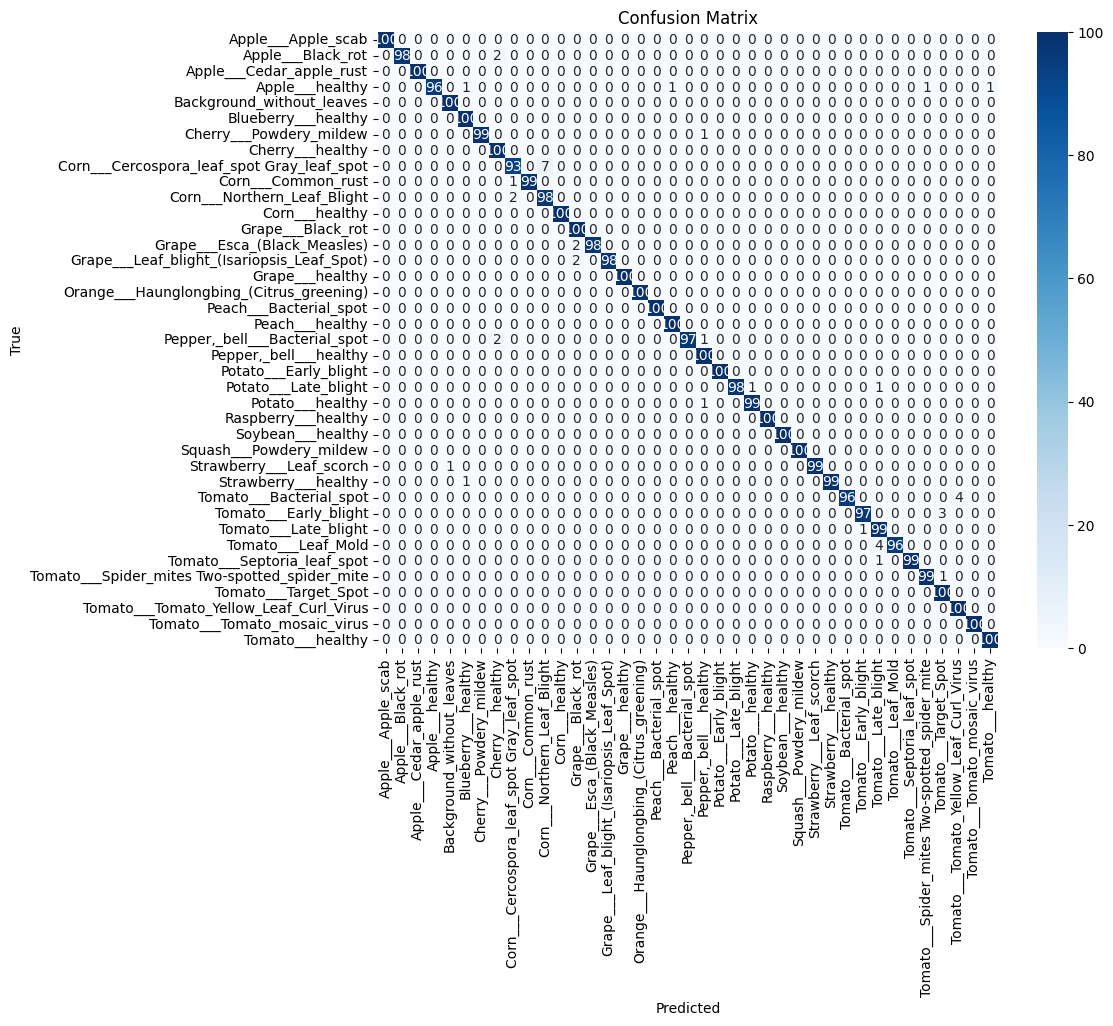

Test Loss: 0.031613, Test Accuracy: 98.90%


In [ ]:
# Run the training and evaluation
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)
model.load_state_dict(torch.load('GhostNetV2_V1_best_model.pth'))  # Load the best model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.2f}%")


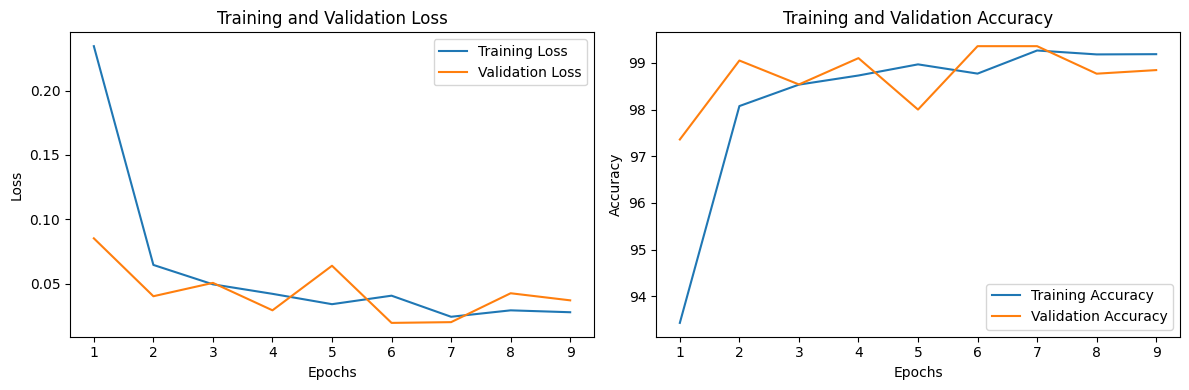

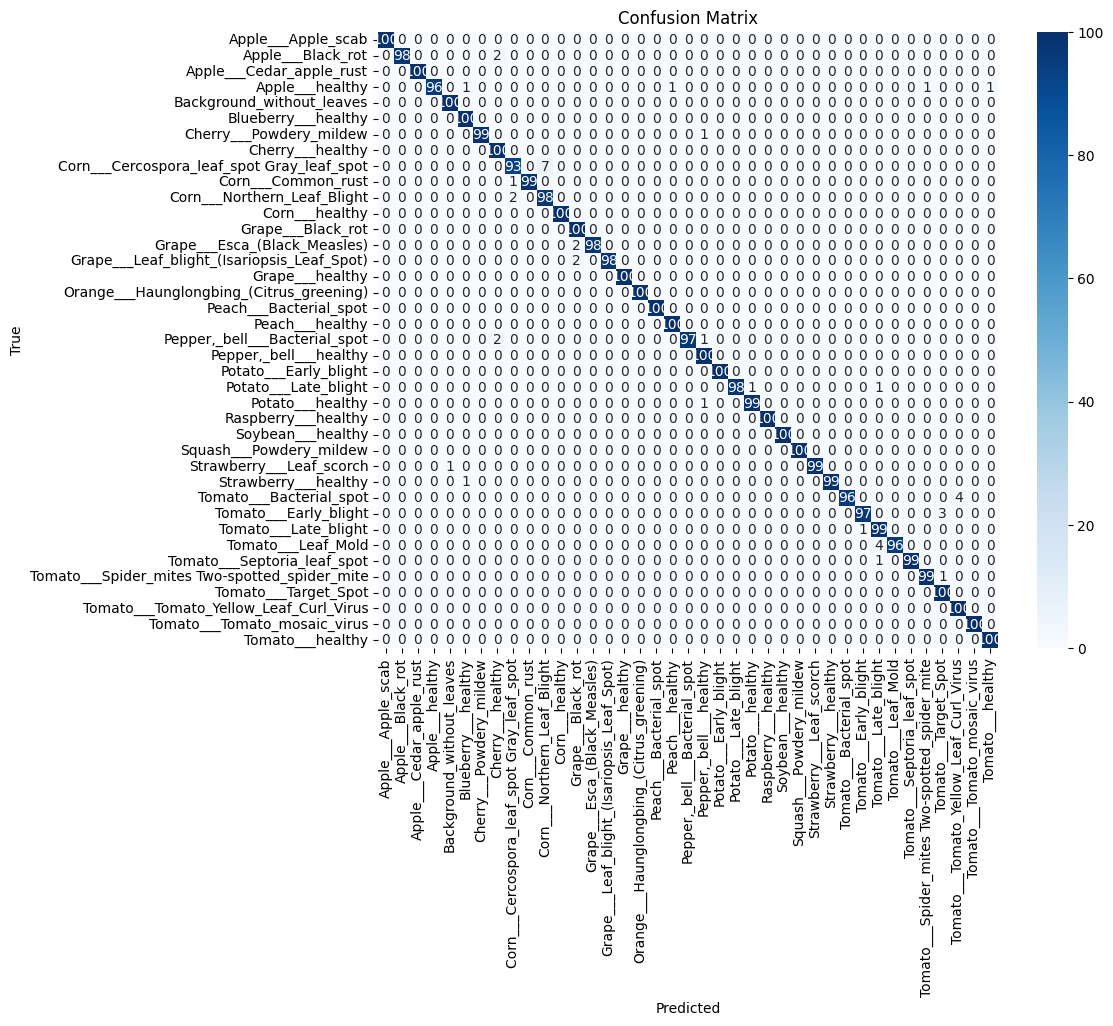

In [ ]:
# Plot metrics and confusion matrix
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(all_labels, all_predictions, train_data.classes)

In [ ]:
# Save the model, optimizer, and other components
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_transforms': train_transforms,
    'val_test_transforms': val_test_transforms,
    'class_to_idx': train_data.class_to_idx,
    'num_classes': num_classes
}
torch.save(checkpoint, '/content/drive/My Drive/model_pth/PlantVillage_CNN_checkpoint_GhostNetV2_V2.pth')